In [1]:
import pandas as pd
import glob
import geopandas as gpd
import matplotlib.pyplot as plt
from mapclassify import Quantiles
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFECV
import seaborn as sns
import numpy as np
import random
import os
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV


In [2]:
data_path = "./harth"

In [3]:
df = pd.read_csv(data_path+ "/S008.csv")

In [4]:
unique_values = df['label'].unique()

# Display the unique values
print(unique_values)

[  6   1   3   7   4   5  13 130 140  14]


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418989 entries, 0 to 418988
Data columns (total 8 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   timestamp  418989 non-null  object 
 1   back_x     418989 non-null  float64
 2   back_y     418989 non-null  float64
 3   back_z     418989 non-null  float64
 4   thigh_x    418989 non-null  float64
 5   thigh_y    418989 non-null  float64
 6   thigh_z    418989 non-null  float64
 7   label      418989 non-null  int64  
dtypes: float64(6), int64(1), object(1)
memory usage: 25.6+ MB


In [6]:
sorted_df_desc = df.sort_values(by='back_z', ascending=False)
sorted_df_desc.tail()

,timestamp,back_x,back_y,back_z,thigh_x,thigh_y,thigh_z,label
25016,2019-01-12 00:08:25.080,-0.702812,0.045427,-0.908946,-0.110607,0.141820,1.024014,7
25015,2019-01-12 00:08:25.060,-0.721633,0.053838,-0.920302,-0.081346,0.138575,1.032711,7
25014,2019-01-12 00:08:25.040,-0.703002,0.064569,-0.922927,-0.070629,0.172352,0.992063,7
398790,2019-01-12 02:16:37.760,-0.801162,0.062681,-0.957426,-0.074258,0.019903,1.014924,7
398791,2019-01-12 02:16:37.780,-0.842687,0.133440,-0.960136,-0.009719,0.076638,0.950905,7


In [7]:
sorted_df_desc.head()

,timestamp,back_x,back_y,back_z,thigh_x,thigh_y,thigh_z,label
60359,2019-01-12 00:21:30.580,-1.838902,0.098316,1.872940,-3.234863,1.372143,3.524602,1
60455,2019-01-12 00:21:32.500,-1.888858,0.480744,1.812570,-2.210547,0.200133,3.716918,1
58980,2019-01-12 00:21:03.000,-1.694332,0.499661,1.801244,-0.999623,-0.279752,0.908946,1
59020,2019-01-12 00:21:03.800,-0.937257,0.145226,1.718867,-0.829141,-1.211112,0.898636,1
60644,2019-01-12 00:21:36.280,-1.629886,-0.410081,1.706579,-1.464934,1.260038,-0.343568,1


In [8]:
# df = df.drop(columns=['Unnamed: 0'])
# df = df.drop(columns=['index'])

In [9]:
null_counts = df.isnull().sum()
print(null_counts)

timestamp    0
back_x       0
back_y       0
back_z       0
thigh_x      0
thigh_y      0
thigh_z      0
label        0
dtype: int64


In [10]:
df.head()

,timestamp,back_x,back_y,back_z,thigh_x,thigh_y,thigh_z,label
0,2019-01-12 00:00:00.000,-2.409951,-0.046434,0.014000,-0.265595,-0.743889,0.562652,6
1,2019-01-12 00:00:00.020,-1.562595,0.171910,0.435377,-0.406350,-0.215105,0.853667,6
2,2019-01-12 00:00:00.040,-1.587608,0.639000,-0.097640,-1.684106,-0.178350,-0.286586,6
3,2019-01-12 00:00:00.060,-0.217441,-0.085718,-0.275723,-0.509119,0.830213,-0.487134,6
4,2019-01-12 00:00:00.080,0.873471,-0.208949,-0.111485,-0.856530,1.145938,-0.819877,6


In [11]:
df.describe()

,back_x,back_y,back_z,thigh_x,thigh_y,thigh_z,label
count,418989.000000,418989.000000,418989.000000,418989.000000,418989.000000,418989.000000,418989.000000
mean,-0.920351,0.040018,-0.326746,-0.332798,0.050361,0.656598,6.661819
std,0.130877,0.107516,0.297591,0.463427,0.218070,0.523197,6.445625
min,-3.066853,-1.209330,-0.960136,-5.922062,-2.857320,-4.233158,1.000000
25%,-0.998823,-0.013310,-0.580225,-0.882999,-0.088989,0.256630,6.000000
50%,-0.972054,0.048302,-0.297335,-0.085027,0.068947,0.950087,7.000000
75%,-0.826290,0.101082,-0.143575,-0.005905,0.166770,0.994429,7.000000
max,0.873471,1.255642,1.872940,2.312848,4.809320,5.324356,140.000000


In [12]:
df = df.dropna(subset=['thigh_x', 'thigh_y', 'thigh_z', 'back_x', 'back_y', 'back_z', 'label'])

In [13]:
df.describe()

,back_x,back_y,back_z,thigh_x,thigh_y,thigh_z,label
count,418989.000000,418989.000000,418989.000000,418989.000000,418989.000000,418989.000000,418989.000000
mean,-0.920351,0.040018,-0.326746,-0.332798,0.050361,0.656598,6.661819
std,0.130877,0.107516,0.297591,0.463427,0.218070,0.523197,6.445625
min,-3.066853,-1.209330,-0.960136,-5.922062,-2.857320,-4.233158,1.000000
25%,-0.998823,-0.013310,-0.580225,-0.882999,-0.088989,0.256630,6.000000
50%,-0.972054,0.048302,-0.297335,-0.085027,0.068947,0.950087,7.000000
75%,-0.826290,0.101082,-0.143575,-0.005905,0.166770,0.994429,7.000000
max,0.873471,1.255642,1.872940,2.312848,4.809320,5.324356,140.000000


In [14]:
df.shape

(418989, 8)

In [15]:
df.head()

,timestamp,back_x,back_y,back_z,thigh_x,thigh_y,thigh_z,label
0,2019-01-12 00:00:00.000,-2.409951,-0.046434,0.014000,-0.265595,-0.743889,0.562652,6
1,2019-01-12 00:00:00.020,-1.562595,0.171910,0.435377,-0.406350,-0.215105,0.853667,6
2,2019-01-12 00:00:00.040,-1.587608,0.639000,-0.097640,-1.684106,-0.178350,-0.286586,6
3,2019-01-12 00:00:00.060,-0.217441,-0.085718,-0.275723,-0.509119,0.830213,-0.487134,6
4,2019-01-12 00:00:00.080,0.873471,-0.208949,-0.111485,-0.856530,1.145938,-0.819877,6


In [16]:
df.describe()

,back_x,back_y,back_z,thigh_x,thigh_y,thigh_z,label
count,418989.000000,418989.000000,418989.000000,418989.000000,418989.000000,418989.000000,418989.000000
mean,-0.920351,0.040018,-0.326746,-0.332798,0.050361,0.656598,6.661819
std,0.130877,0.107516,0.297591,0.463427,0.218070,0.523197,6.445625
min,-3.066853,-1.209330,-0.960136,-5.922062,-2.857320,-4.233158,1.000000
25%,-0.998823,-0.013310,-0.580225,-0.882999,-0.088989,0.256630,6.000000
50%,-0.972054,0.048302,-0.297335,-0.085027,0.068947,0.950087,7.000000
75%,-0.826290,0.101082,-0.143575,-0.005905,0.166770,0.994429,7.000000
max,0.873471,1.255642,1.872940,2.312848,4.809320,5.324356,140.000000


In [17]:
df['timestamp'] = pd.to_datetime(df['timestamp'])
# df = df.drop('timestamp', axis=1)

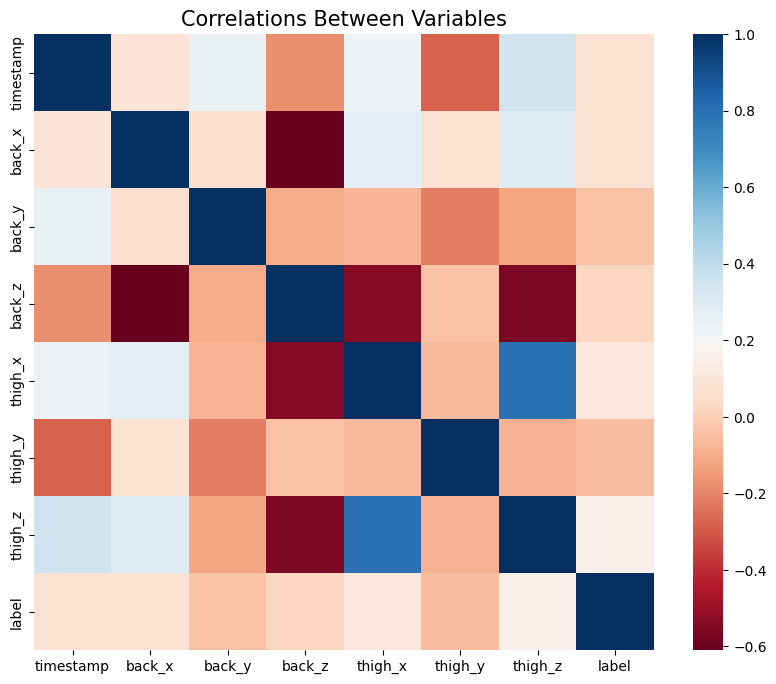

In [18]:
plt.figure(figsize=(10,8))
sns.heatmap(df.corr(), cmap="RdBu")
plt.title("Correlations Between Variables", size=15)
plt.show()

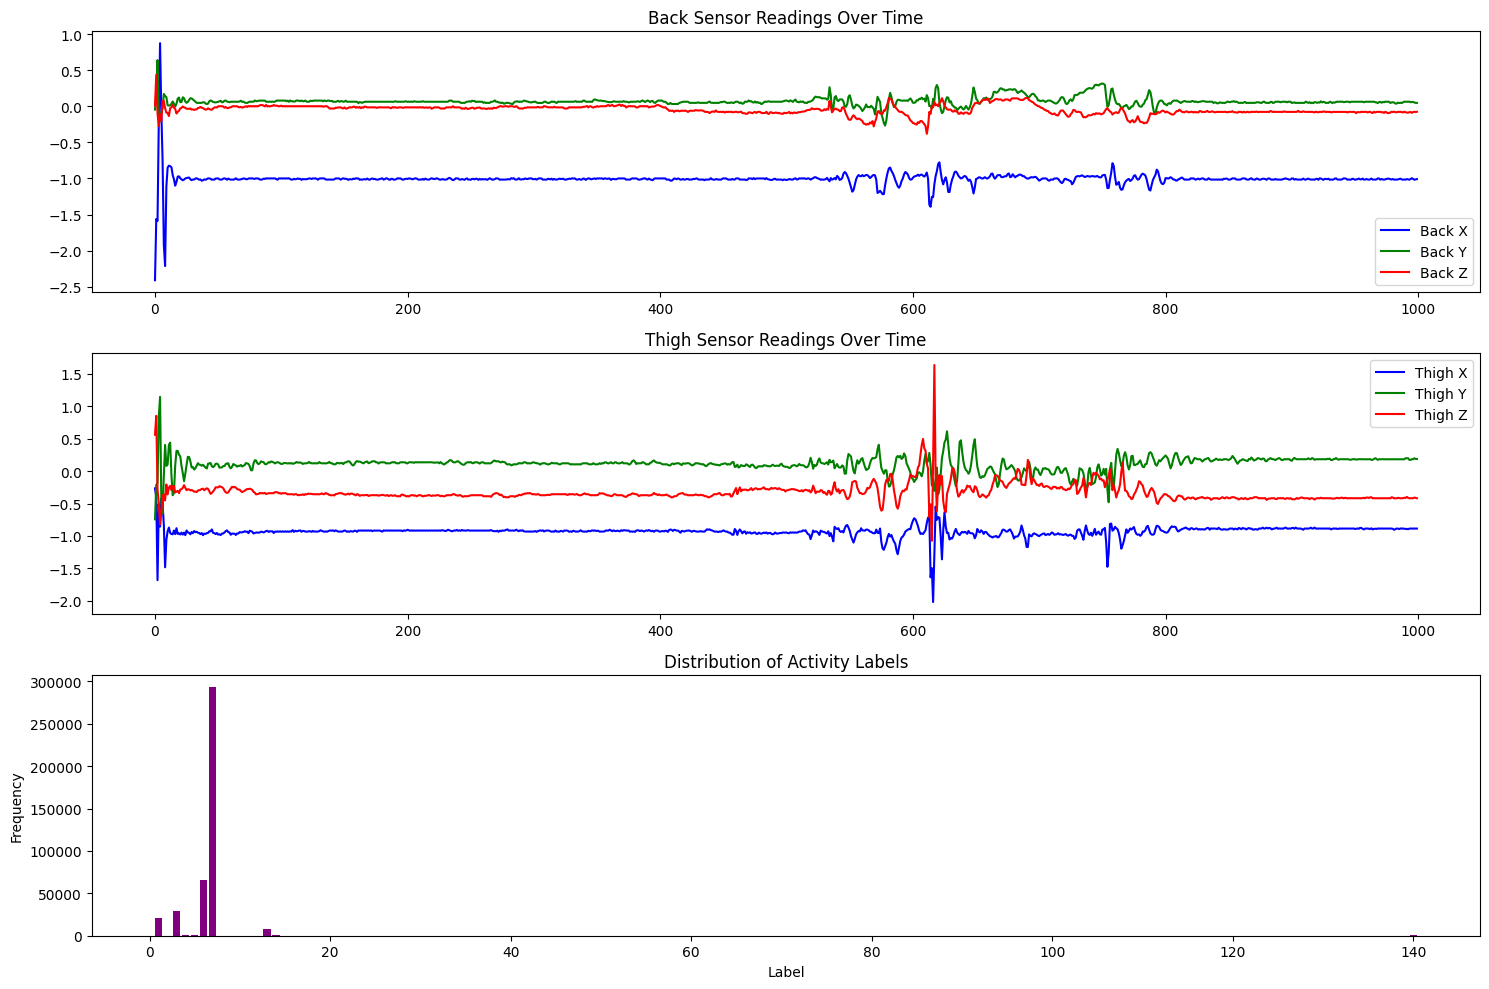

In [19]:
plt.figure(figsize=(15, 10))

plt.subplot(3, 1, 1)
plt.plot(df['back_x'].iloc[:1000], label='Back X', color='b')
plt.plot(df['back_y'].iloc[:1000], label='Back Y', color='g')
plt.plot(df['back_z'].iloc[:1000], label='Back Z', color='r')
plt.title('Back Sensor Readings Over Time')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(df['thigh_x'].iloc[:1000], label='Thigh X', color='b')
plt.plot(df['thigh_y'].iloc[:1000], label='Thigh Y', color='g')
plt.plot(df['thigh_z'].iloc[:1000], label='Thigh Z', color='r')
plt.title('Thigh Sensor Readings Over Time')
plt.legend()

plt.subplot(3, 1, 3)
plt.bar(df['label'].value_counts().index, df['label'].value_counts().values, color='purple')
plt.title('Distribution of Activity Labels')
plt.xlabel('Label')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [20]:
# df.replace([float('inf'), float('-inf')], pd.NA, inplace=True)
# null_counts = df.isnull().sum()
# print(null_counts)
# df.describe()

In [21]:
# df.replace([float('inf'), float('-inf')], pd.NA, inplace=True)
# df = df.replace([np.inf, -np.inf], np.nan)  # Replace all inf/-inf with NaN
# null_counts = df.isnull().sum()
# print(null_counts)
# df.dropna(inplace=True)
# df.describe()

In [22]:
#df.tail()

In [23]:
#df.head()

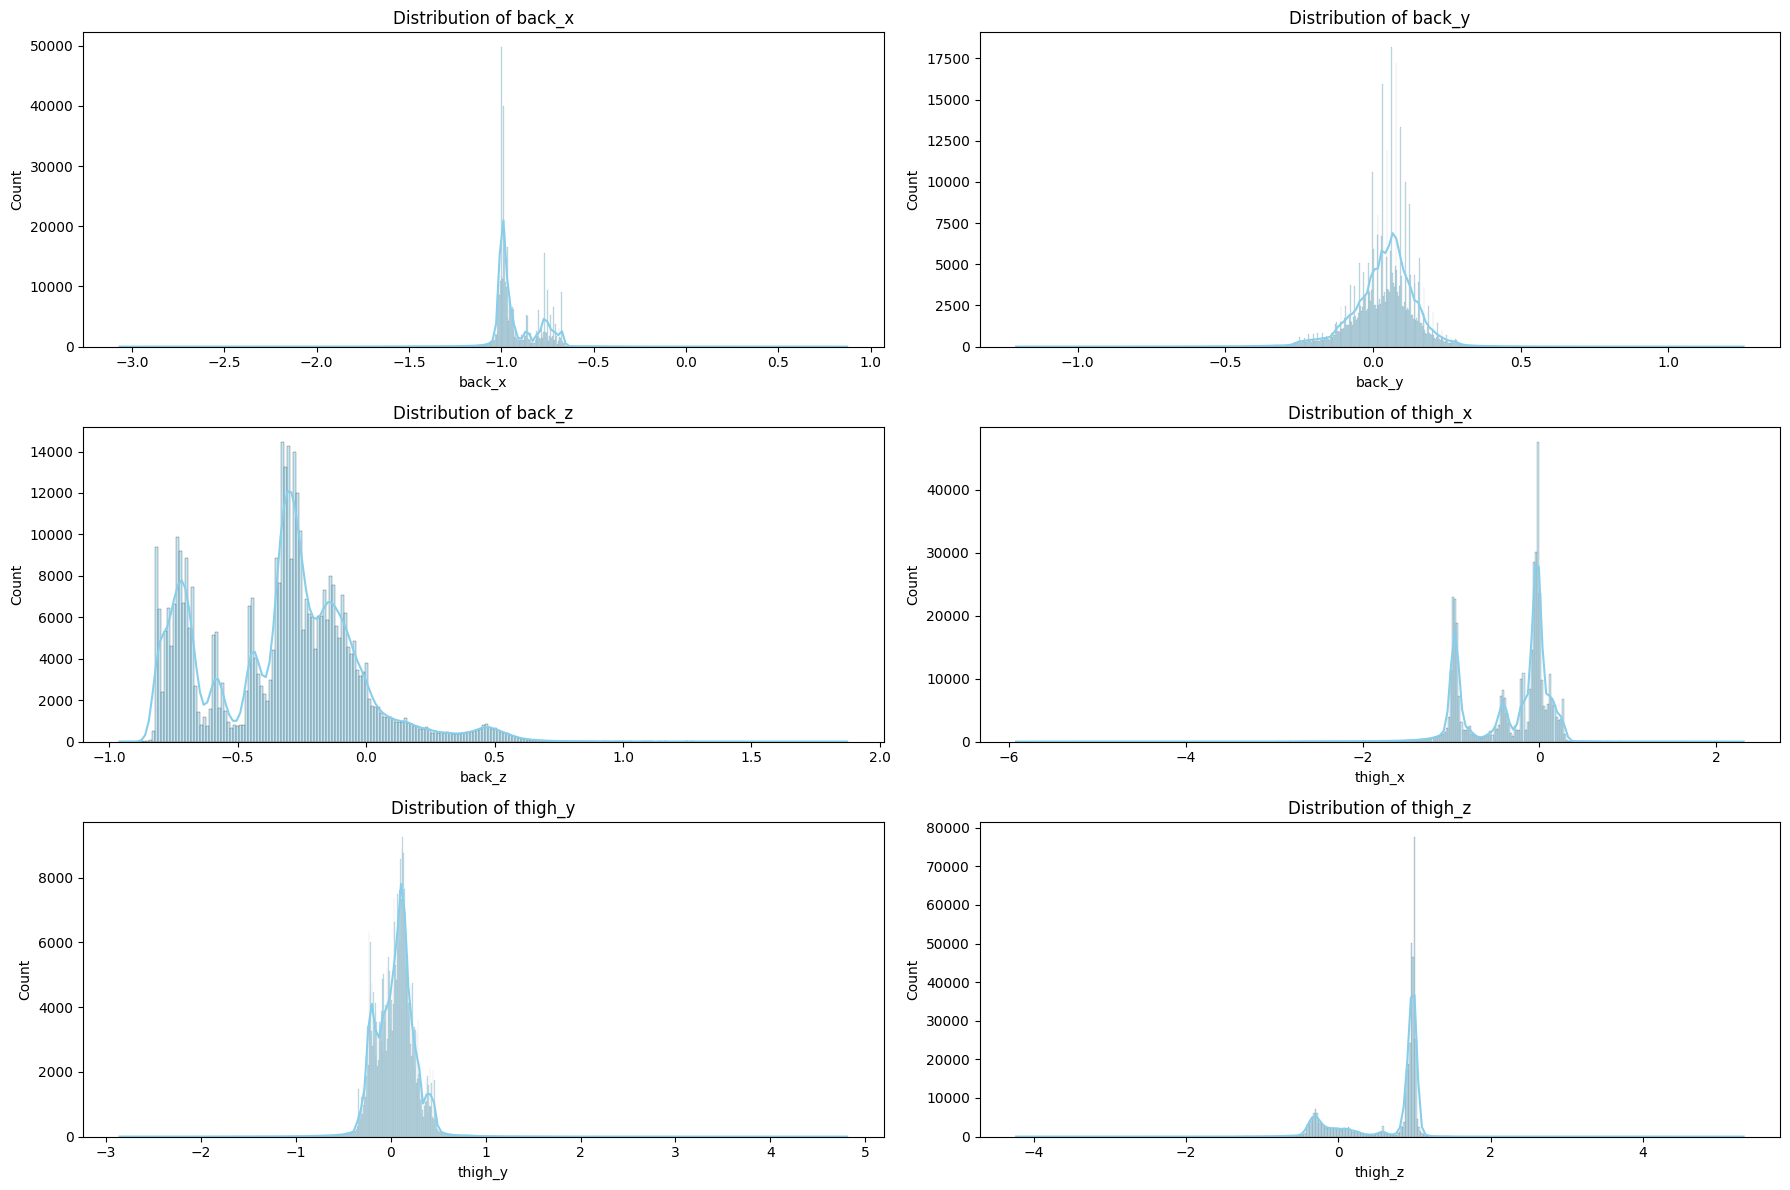

In [24]:
plt.figure(figsize=(18, 12))

sensor_columns = ['back_x', 'back_y', 'back_z', 'thigh_x', 'thigh_y', 'thigh_z']
for i, column in enumerate(sensor_columns, 1):
    plt.subplot(3, 2, i)
    sns.histplot(df[column], kde=True, color='skyblue')
    plt.title(f'Distribution of {column}')

plt.tight_layout()
plt.show()

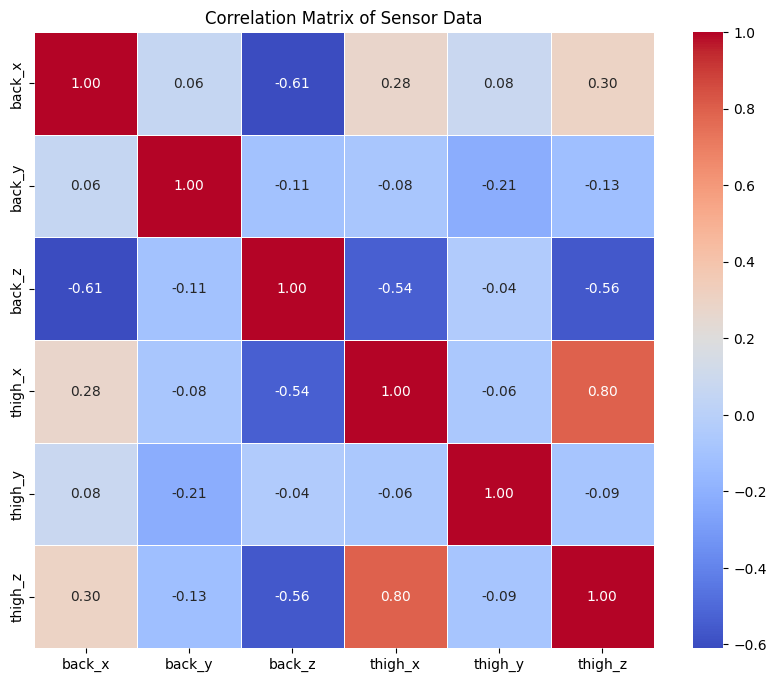

In [25]:
# Correlation matrix
correlation_matrix = df[sensor_columns].corr()

# Plotting the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix of Sensor Data')
plt.show()

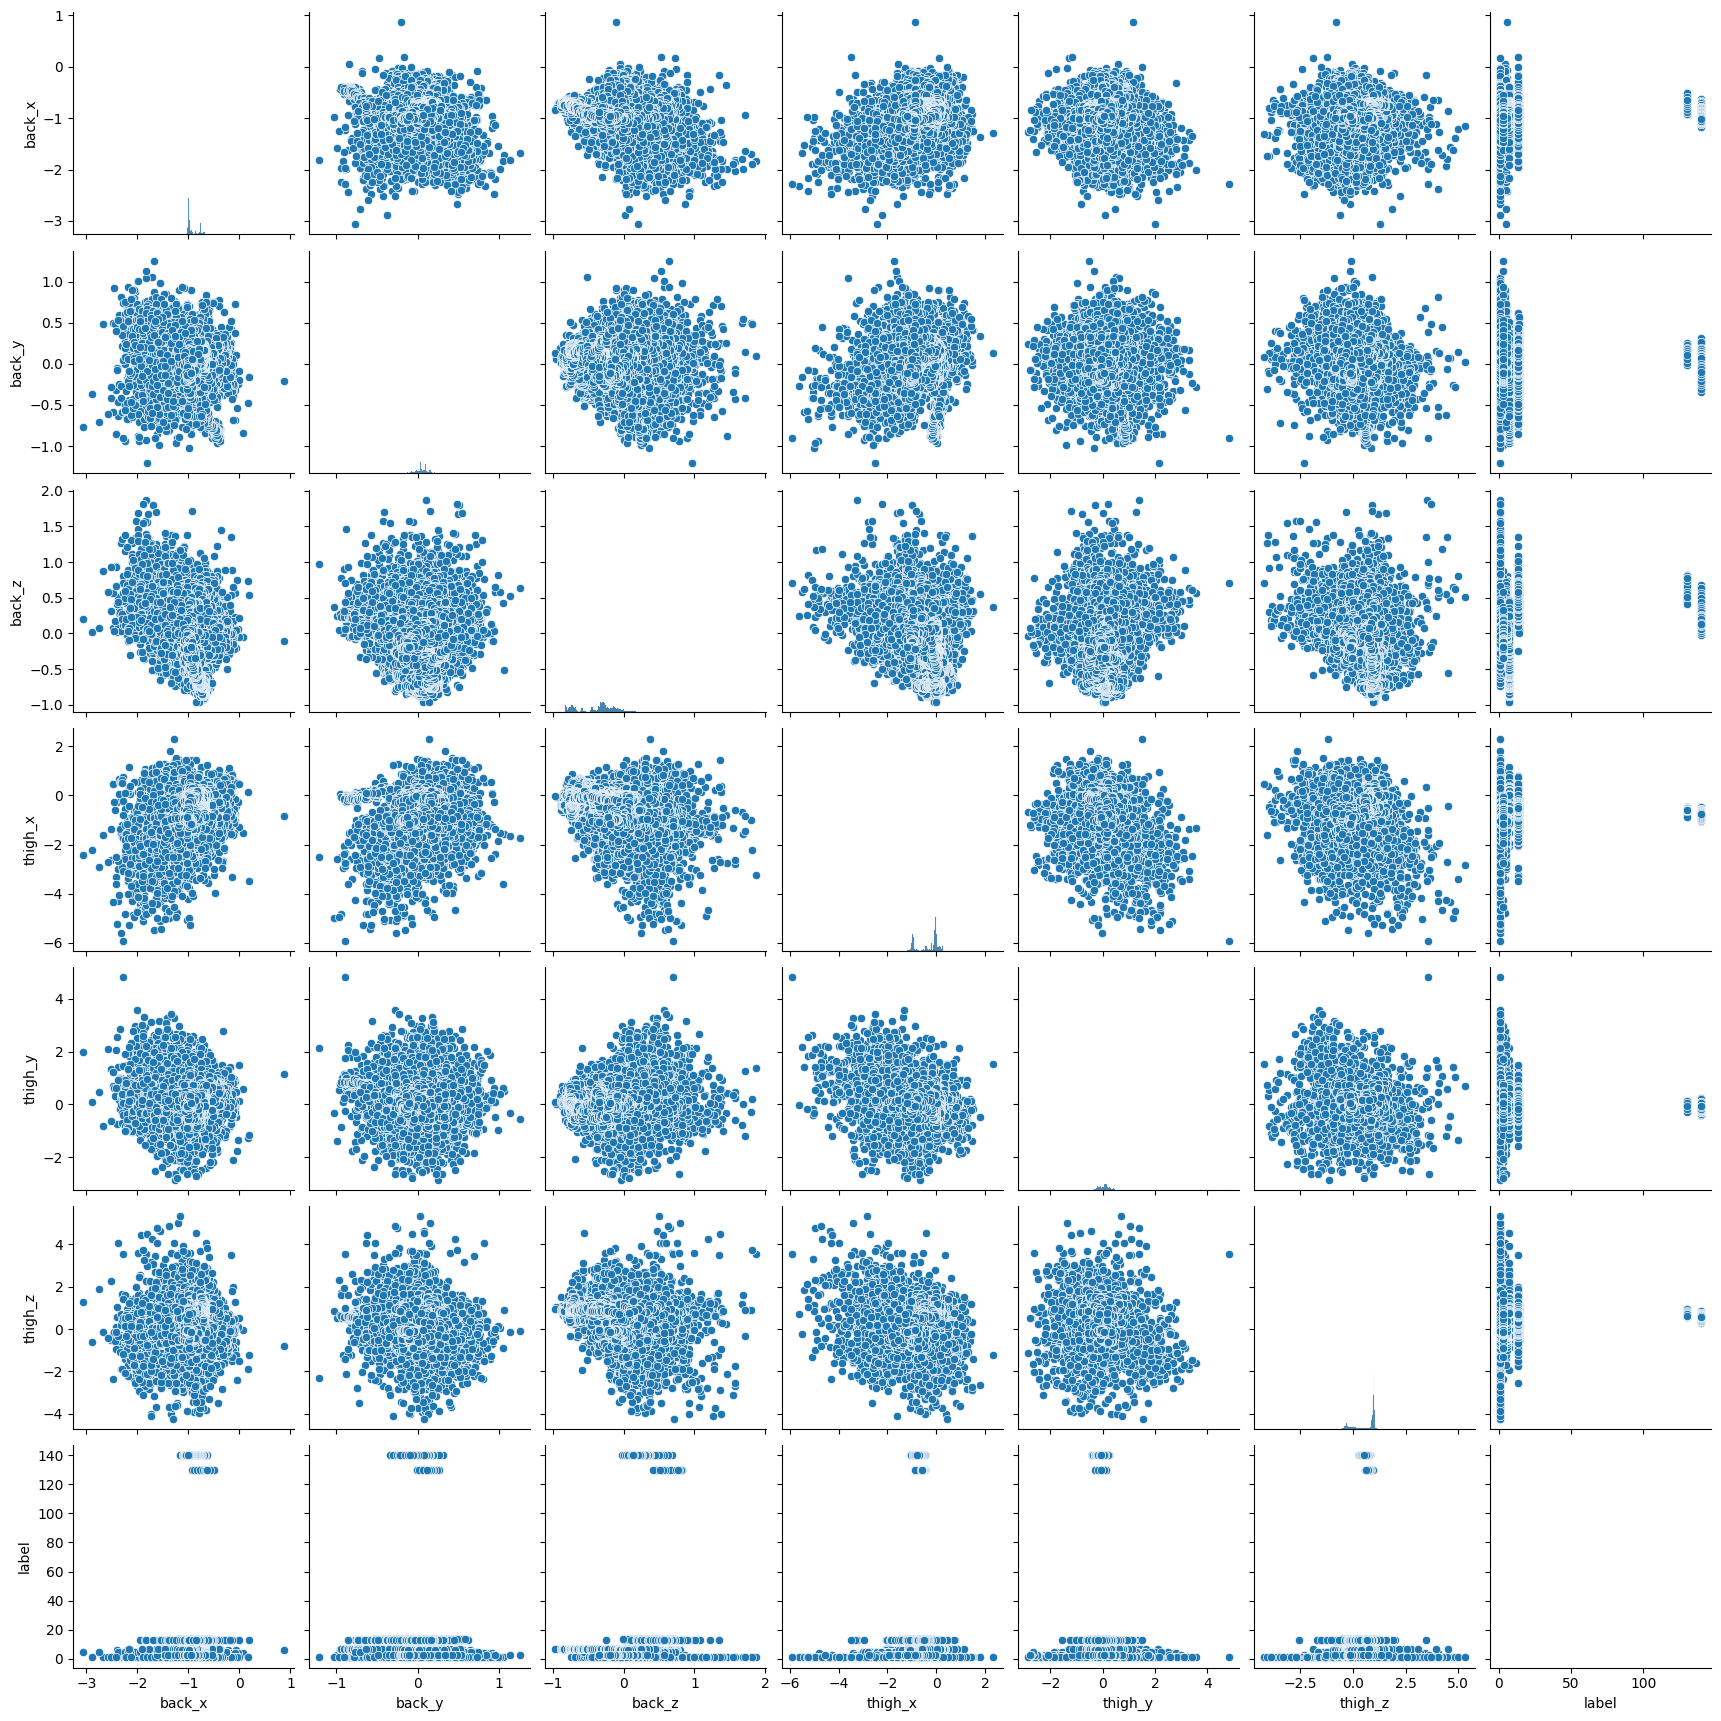

In [26]:
sns.pairplot(df)

In [27]:
features = df[['thigh_x', 'thigh_y', 'thigh_z', 'back_x', 'back_y', 'back_z']].dropna()
target = df['label'][features.index]  # Ensure alignment of features and target
# Scale features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_scaled, target, test_size=0.2, random_state=42)

# Initialize models
models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    'k-NN': KNeighborsRegressor(n_neighbors=13),  # Default number of neighbors
}

# Train, predict, and evaluate each model
for name, model in models.items():
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    r2 = r2_score(y_test, predictions)
    mse = mean_squared_error(y_test, predictions)
    print(f"{name} - R-squared (Model Accuracy): {r2:.4f}, Mean Squared Error: {mse:.2f}")


Linear Regression - R-squared (Model Accuracy): 0.0586, Mean Squared Error: 37.06
Decision Tree - R-squared (Model Accuracy): 0.3886, Mean Squared Error: 24.07
Random Forest - R-squared (Model Accuracy): 0.7068, Mean Squared Error: 11.54
Gradient Boosting - R-squared (Model Accuracy): 0.4124, Mean Squared Error: 23.14
k-NN - R-squared (Model Accuracy): 0.7045, Mean Squared Error: 11.64
